In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as pl
from pprint import pprint
import collections
import itertools
import random

pl.rcParams['figure.figsize'] = [20, 20]

In [3]:
g = nx.read_graphml('all.graphml')
if g.is_directed():
    g = g.to_undirected()
nodes = g.nodes(data=True)
edges = g.edges()
info = nx.info(g)
print(info)
nodes = {k: v for k, v in nodes}
edges = tuple((k, v) for k, v in edges)

Name: 
Type: MultiGraph
Number of nodes: 22405
Number of edges: 76660
Average degree:   6.8431


In [4]:
esample = random.sample(edges, 25)
print("Edge Sample:")
pprint(esample)

nsample = {'left': {}, 'right': {}, '-': {}}
for u, v in esample:
    uclust = g.nodes[u]['cluster']
    vclust = g.nodes[v]['cluster']
    if u not in nsample[uclust]:
        nsample[uclust][u] = tuple(g.neighbors(u))
    if v not in nsample[vclust]:
        nsample[vclust][v] = tuple(g.neighbors(v))

print("Nodes from Edges Sample:")
pprint(nsample, depth=2)

Edge Sample:
[('n14351', 'n22096'),
 ('n7472', 'n10343'),
 ('n14820', 'n16898'),
 ('n5382', 'n11675'),
 ('n3870', 'n14644'),
 ('n14388', 'n16920'),
 ('n14286', 'n20791'),
 ('n1244', 'n15101'),
 ('n3545', 'n18216'),
 ('n4777', 'n8309'),
 ('n14325', 'n20298'),
 ('n3853', 'n19681'),
 ('n14765', 'n20489'),
 ('n4933', 'n8078'),
 ('n13505', 'n22315'),
 ('n18052', 'n21155'),
 ('n14588', 'n17630'),
 ('n4957', 'n8322'),
 ('n18878', 'n19716'),
 ('n4535', 'n11738'),
 ('n4557', 'n21953'),
 ('n6271', 'n14162'),
 ('n249', 'n5119'),
 ('n14406', 'n21953'),
 ('n4205', 'n4326')]
Nodes from Edges Sample:
{'-': {'n14406': (...), 'n14820': (...,), 'n16898': (...)},
 'left': {'n10343': (...),
          'n11675': (...),
          'n13505': (...),
          'n14162': (...),
          'n14325': (...),
          'n14388': (...),
          'n14588': (...),
          'n16920': (...),
          'n17630': (...),
          'n20298': (...),
          'n22315': (...),
          'n4777': (...),
          'n5382': (...)

In [5]:
def get_cluster(graph, node, field='cluster'):
    """
    getter for cluster value of node in graph.
    """
    return graph.nodes[node][field]


def ratio_calc(graph, node, s=1, o=0, n=0.5,
               field='cluster', neutral='-', right='right', left='left', 
               no_neighbor_value=None, no_alignment_value=None):
    """
    Perform a ratio calculation on given node in graph.
    
    ratio = (s * Ns + o * No + n * Nn) / N
    
    Where:
        Ns, No, Nn, and N are number of neighbors that are the same, other, neutral, and total (resp).
        s, o, and n are tuning parameters for same, other, and neutral (resp).
    """
    nbors = tuple(graph.neighbors(node))
    nclust = get_cluster(graph, node, field)
    
    if nclust == neutral:
        return no_alignment_value
    if 0 == len(nbors):
        return no_neighbor_value
    
    nother = right if nclust == left else left
    counts = { k: float(len(list(v))) for k,v in itertools.groupby(nbors, key=lambda y: get_cluster(graph, y, field)) }
    ratio = ((s * counts.get(nclust, 0)) + (o * counts.get(nother, 0)) + (n * counts.get(neutral, 0))) \
                / len(nbors)
    return ratio

ratios = { n: ratio_calc(g, n) for n in g.nodes() }
ratios = { k: v for k, v in ratios.items() if v }

See also differences between mention and retweet distributions.
Retweet bias overpowers nuance in mention network dissortative mixing.


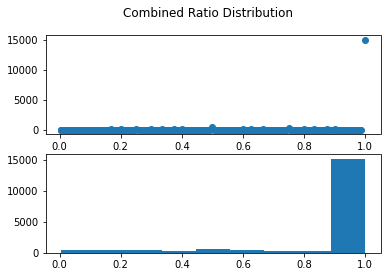

In [6]:
d = { k: len(tuple(v)) for k, v in itertools.groupby(sorted(ratios.values())) }
plot, (ap, bp) = pl.subplots(2)
plot.suptitle('Combined Ratio Distribution')
ap.scatter(d.keys(), d.values())
bp.hist(ratios.values(), bins=9)
plot.show()

print("See also differences between mention and retweet distributions.")
print("Retweet bias overpowers nuance in mention network dissortative mixing.")

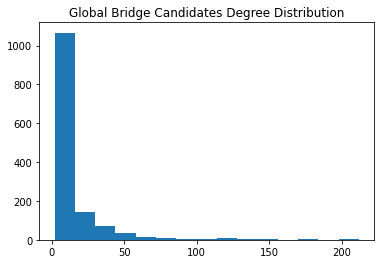

In [7]:
bridge_min = .25
bridge_max = .60

candidates = { k: len(list(g.neighbors(k))) for k, v in ratios.items() if bridge_min <= v <= bridge_max }

d = { k: len(tuple(v)) for k, v in itertools.groupby(candidates.items(), key=lambda y: y[1]) }
pl.plot()
pl.title('Global Bridge Candidates Degree Distribution')
pl.hist(candidates.values(), bins=15)
plot.show()

In [8]:
# we have some solid global candidates >100 degree
bridge_deg = 100

bridges = collections.OrderedDict()
for k, v in sorted(candidates.items(), key=lambda y: y[1], reverse=True):
    if v < bridge_deg:
        break
    bridges[k] = v

print("{} Bridge Candidates w/ Degree > {} [{}, {}]".format(len(bridges.items()), bridge_deg, bridge_min, bridge_max))
print("=====================================")
print(" node   deg  ratio")
print("-------------------------------------")
for k, v in bridges.items():
    print("{: <6}  {:3d}  {:.2f}".format(k, v, ratios[k]))

20 Bridge Candidates w/ Degree > 100 [0.25, 0.6]
 node   deg  ratio
-------------------------------------
n6047   212  0.44
n5711   200  0.31
n7395   180  0.31
n5606   171  0.36
n11139  165  0.55
n14357  153  0.29
n17573  147  0.29
n12129  146  0.38
n2831   145  0.32
n21567  140  0.43
n2765   128  0.28
n11961  124  0.40
n9254   123  0.44
n6123   120  0.37
n12049  119  0.50
n6715   117  0.44
n3790   115  0.36
n11466  114  0.30
n3870   111  0.35
n7472   109  0.51


In [46]:
cutoff = 2
samples_threshold = .75
samples = { k: v for k, v in ratios.items() if v > samples_threshold and g.nodes[k]['cluster'] != '-' }
samples = dict(random.sample(samples.items(), 100))

In [47]:
def recommend_links(graph, u, uratio, fn='cluster', none_value='-', none_weight=0.33, dist=3):
    results = {}
    cluster = graph.nodes[u][fn]
    nearby = { n: l for n, l in nx.single_source_shortest_path_length(graph, u, cutoff=dist).items() if l > 1 }
    unbors = set(graph.neighbors(u))
    for v, dist in nearby.items():
        vcluster = graph.nodes[v][fn]
        if vcluster != cluster:
            vnbors = set(graph.neighbors(v))
            shared = unbors & vnbors
            weight = none_weight if vcluster == none_value else 1
            score = weight / dist * max(1, len(shared))
            results[v] = (score, vcluster)
    return sorted(results.items(), key=lambda y: y[1][0], reverse=True)

for u, ratio in samples.items():
    pprint(dict(node=u, nodecl=g.nodes[u]['cluster'], ratio=ratio, recommend=recommend_links(g, u, ratio, dist=3)))

{'node': 'n21595',
 'nodecl': 'right',
 'ratio': 1.0,
 'recommend': [('n12063', (0.5, 'left')),
               ('n20665', (0.5, 'left')),
               ('n2624', (0.5, 'left')),
               ('n14941', (0.5, 'left')),
               ('n850', (0.5, 'left')),
               ('n14322', (0.5, 'left')),
               ('n20315', (0.3333333333333333, 'left')),
               ('n8430', (0.3333333333333333, 'left')),
               ('n18079', (0.3333333333333333, 'left')),
               ('n4186', (0.3333333333333333, 'left')),
               ('n5392', (0.3333333333333333, 'left')),
               ('n10776', (0.3333333333333333, 'left')),
               ('n20395', (0.3333333333333333, 'left')),
               ('n21395', (0.3333333333333333, 'left')),
               ('n1280', (0.3333333333333333, 'left')),
               ('n21183', (0.3333333333333333, 'left')),
               ('n3028', (0.3333333333333333, 'left')),
               ('n22189', (0.3333333333333333, 'left')),
               ('n

               ('n7982', (0.11, '-')),
               ('n19280', (0.11, '-')),
               ('n3928', (0.11, '-')),
               ('n12156', (0.11, '-')),
               ('n8770', (0.11, '-')),
               ('n19243', (0.11, '-')),
               ('n2545', (0.11, '-')),
               ('n14046', (0.11, '-')),
               ('n4835', (0.11, '-')),
               ('n5672', (0.11, '-')),
               ('n15497', (0.11, '-')),
               ('n20679', (0.11, '-')),
               ('n19040', (0.11, '-')),
               ('n14164', (0.11, '-')),
               ('n18469', (0.11, '-')),
               ('n10062', (0.11, '-')),
               ('n21915', (0.11, '-')),
               ('n4840', (0.11, '-')),
               ('n14510', (0.11, '-')),
               ('n18231', (0.11, '-')),
               ('n8660', (0.11, '-')),
               ('n22243', (0.11, '-')),
               ('n10208', (0.11, '-')),
               ('n18909', (0.11, '-')),
               ('n4345', (0.11, '-')),
         

               ('n2846', (0.11, '-')),
               ('n11354', (0.11, '-')),
               ('n4602', (0.11, '-')),
               ('n16662', (0.11, '-')),
               ('n4820', (0.11, '-')),
               ('n20837', (0.11, '-')),
               ('n3385', (0.11, '-')),
               ('n8608', (0.11, '-')),
               ('n1035', (0.11, '-')),
               ('n6640', (0.11, '-')),
               ('n1184', (0.11, '-')),
               ('n16234', (0.11, '-')),
               ('n4212', (0.11, '-')),
               ('n13804', (0.11, '-')),
               ('n14315', (0.11, '-')),
               ('n20772', (0.11, '-')),
               ('n17566', (0.11, '-')),
               ('n12346', (0.11, '-')),
               ('n6135', (0.11, '-')),
               ('n13733', (0.11, '-')),
               ('n5585', (0.11, '-')),
               ('n17160', (0.11, '-')),
               ('n11820', (0.11, '-')),
               ('n13686', (0.11, '-')),
               ('n4859', (0.11, '-')),
            

               ('n12606', (0.5, 'left')),
               ('n4880', (0.5, 'left')),
               ('n10031', (0.5, 'left')),
               ('n4261', (0.5, 'left')),
               ('n7911', (0.5, 'left')),
               ('n14232', (0.5, 'left')),
               ('n3882', (0.5, 'left')),
               ('n13730', (0.5, 'left')),
               ('n12728', (0.5, 'left')),
               ('n2665', (0.5, 'left')),
               ('n20664', (0.5, 'left')),
               ('n19619', (0.5, 'left')),
               ('n18491', (0.5, 'left')),
               ('n14321', (0.5, 'left')),
               ('n9604', (0.5, 'left')),
               ('n14583', (0.5, 'left')),
               ('n9043', (0.5, 'left')),
               ('n5054', (0.5, 'left')),
               ('n14682', (0.5, 'left')),
               ('n20928', (0.5, 'left')),
               ('n22331', (0.5, 'left')),
               ('n20631', (0.5, 'left')),
               ('n19621', (0.5, 'left')),
               ('n13316', (0.5, 'left')),


               ('n11654', (0.3333333333333333, 'right')),
               ('n17003', (0.3333333333333333, 'right')),
               ('n5460', (0.3333333333333333, 'right')),
               ('n2526', (0.3333333333333333, 'right')),
               ('n21973', (0.3333333333333333, 'right')),
               ('n16160', (0.3333333333333333, 'right')),
               ('n9386', (0.3333333333333333, 'right')),
               ('n9825', (0.3333333333333333, 'right')),
               ('n22089', (0.3333333333333333, 'right')),
               ('n16391', (0.3333333333333333, 'right')),
               ('n4761', (0.3333333333333333, 'right')),
               ('n22297', (0.3333333333333333, 'right')),
               ('n15742', (0.3333333333333333, 'right')),
               ('n20257', (0.3333333333333333, 'right')),
               ('n5936', (0.3333333333333333, 'right')),
               ('n19343', (0.3333333333333333, 'right')),
               ('n2686', (0.3333333333333333, 'right')),
               ('n146

{'node': 'n18285',
 'nodecl': 'right',
 'ratio': 1.0,
 'recommend': [('n83', (1.0, 'left')),
               ('n18306', (1.0, 'left')),
               ('n15424', (1.0, 'left')),
               ('n14321', (1.0, 'left')),
               ('n10079', (1.0, 'left')),
               ('n14322', (1.0, 'left')),
               ('n8891', (1.0, 'left')),
               ('n6445', (0.5, 'left')),
               ('n9615', (0.5, 'left')),
               ('n16110', (0.5, 'left')),
               ('n10078', (0.5, 'left')),
               ('n6146', (0.5, 'left')),
               ('n5325', (0.5, 'left')),
               ('n3434', (0.5, 'left')),
               ('n10196', (0.5, 'left')),
               ('n227', (0.5, 'left')),
               ('n9972', (0.5, 'left')),
               ('n20428', (0.5, 'left')),
               ('n12297', (0.5, 'left')),
               ('n850', (0.5, 'left')),
               ('n2444', (0.5, 'left')),
               ('n8434', (0.5, 'left')),
               ('n12770', (0.5, 'left'

               ('n11159', (0.11, '-')),
               ('n8356', (0.11, '-')),
               ('n19132', (0.11, '-')),
               ('n20123', (0.11, '-')),
               ('n18709', (0.11, '-')),
               ('n20448', (0.11, '-')),
               ('n459', (0.11, '-')),
               ('n10449', (0.11, '-')),
               ('n15865', (0.11, '-')),
               ('n21294', (0.11, '-')),
               ('n20128', (0.11, '-')),
               ('n12466', (0.11, '-')),
               ('n9128', (0.11, '-')),
               ('n13430', (0.11, '-')),
               ('n20301', (0.11, '-')),
               ('n16627', (0.11, '-')),
               ('n2274', (0.11, '-')),
               ('n3121', (0.11, '-')),
               ('n13061', (0.11, '-')),
               ('n18051', (0.11, '-')),
               ('n18147', (0.11, '-')),
               ('n9817', (0.11, '-')),
               ('n5900', (0.11, '-')),
               ('n18136', (0.11, '-')),
               ('n2661', (0.11, '-')),
         

               ('n14047', (0.3333333333333333, 'left')),
               ('n2747', (0.3333333333333333, 'left')),
               ('n21898', (0.3333333333333333, 'left')),
               ('n20654', (0.3333333333333333, 'left')),
               ('n18293', (0.3333333333333333, 'left')),
               ('n6258', (0.3333333333333333, 'left')),
               ('n11989', (0.3333333333333333, 'left')),
               ('n17579', (0.3333333333333333, 'left')),
               ('n3858', (0.3333333333333333, 'left')),
               ('n9045', (0.3333333333333333, 'left')),
               ('n13598', (0.3333333333333333, 'left')),
               ('n2792', (0.3333333333333333, 'left')),
               ('n16983', (0.3333333333333333, 'left')),
               ('n3660', (0.3333333333333333, 'left')),
               ('n19691', (0.3333333333333333, 'left')),
               ('n6410', (0.3333333333333333, 'left')),
               ('n6294', (0.3333333333333333, 'left')),
               ('n21751', (0.3333333333

               ('n19461', (0.3333333333333333, 'left')),
               ('n8964', (0.3333333333333333, 'left')),
               ('n18184', (0.3333333333333333, 'left')),
               ('n9194', (0.3333333333333333, 'left')),
               ('n6047', (0.3333333333333333, 'left')),
               ('n14601', (0.3333333333333333, 'left')),
               ('n8891', (0.3333333333333333, 'left')),
               ('n7460', (0.3333333333333333, 'left')),
               ('n5066', (0.3333333333333333, 'left')),
               ('n5694', (0.3333333333333333, 'left')),
               ('n5917', (0.3333333333333333, 'left')),
               ('n5577', (0.3333333333333333, 'left')),
               ('n7716', (0.3333333333333333, 'left')),
               ('n16486', (0.3333333333333333, 'left')),
               ('n4417', (0.3333333333333333, 'left')),
               ('n20663', (0.3333333333333333, 'left')),
               ('n9043', (0.3333333333333333, 'left')),
               ('n5054', (0.333333333333333

               ('n20241', (0.3333333333333333, 'left')),
               ('n5556', (0.3333333333333333, 'left')),
               ('n19291', (0.3333333333333333, 'left')),
               ('n22224', (0.3333333333333333, 'left')),
               ('n2321', (0.3333333333333333, 'left')),
               ('n9096', (0.3333333333333333, 'left')),
               ('n12461', (0.3333333333333333, 'left')),
               ('n4812', (0.3333333333333333, 'left')),
               ('n14047', (0.3333333333333333, 'left')),
               ('n983', (0.3333333333333333, 'left')),
               ('n812', (0.3333333333333333, 'left')),
               ('n9373', (0.3333333333333333, 'left')),
               ('n11887', (0.3333333333333333, 'left')),
               ('n4476', (0.3333333333333333, 'left')),
               ('n11320', (0.3333333333333333, 'left')),
               ('n21898', (0.3333333333333333, 'left')),
               ('n11315', (0.3333333333333333, 'left')),
               ('n20521', (0.333333333333

 'ratio': 1.0,
 'recommend': [('n3148', (0.5, 'right')),
               ('n21632', (0.5, 'right')),
               ('n12210', (0.5, 'right')),
               ('n11307', (0.5, 'right')),
               ('n21973', (0.3333333333333333, 'right')),
               ('n10385', (0.3333333333333333, 'right')),
               ('n293', (0.3333333333333333, 'right')),
               ('n6543', (0.3333333333333333, 'right')),
               ('n16542', (0.3333333333333333, 'right')),
               ('n9386', (0.3333333333333333, 'right')),
               ('n16921', (0.3333333333333333, 'right')),
               ('n9879', (0.3333333333333333, 'right')),
               ('n4985', (0.3333333333333333, 'right')),
               ('n15696', (0.3333333333333333, 'right')),
               ('n1021', (0.3333333333333333, 'right')),
               ('n1463', (0.3333333333333333, 'right')),
               ('n20696', (0.3333333333333333, 'right')),
               ('n21654', (0.3333333333333333, 'right')),
          

               ('n15774', (0.3333333333333333, 'left')),
               ('n850', (0.3333333333333333, 'left')),
               ('n22185', (0.3333333333333333, 'left')),
               ('n5251', (0.3333333333333333, 'left')),
               ('n21679', (0.3333333333333333, 'left')),
               ('n5189', (0.3333333333333333, 'left')),
               ('n17165', (0.3333333333333333, 'left')),
               ('n4532', (0.3333333333333333, 'left')),
               ('n16908', (0.3333333333333333, 'left')),
               ('n7316', (0.3333333333333333, 'left')),
               ('n3503', (0.3333333333333333, 'left')),
               ('n6043', (0.3333333333333333, 'left')),
               ('n17076', (0.3333333333333333, 'left')),
               ('n12239', (0.3333333333333333, 'left')),
               ('n14941', (0.3333333333333333, 'left')),
               ('n152', (0.3333333333333333, 'left')),
               ('n9015', (0.3333333333333333, 'left')),
               ('n14542', (0.3333333333333

               ('n16433', (0.3333333333333333, 'right')),
               ('n523', (0.3333333333333333, 'right')),
               ('n2656', (0.3333333333333333, 'right')),
               ('n12646', (0.3333333333333333, 'right')),
               ('n10559', (0.3333333333333333, 'right')),
               ('n10580', (0.3333333333333333, 'right')),
               ('n2464', (0.3333333333333333, 'right')),
               ('n8191', (0.3333333333333333, 'right')),
               ('n10773', (0.3333333333333333, 'right')),
               ('n20218', (0.3333333333333333, 'right')),
               ('n19034', (0.3333333333333333, 'right')),
               ('n22176', (0.3333333333333333, 'right')),
               ('n1273', (0.3333333333333333, 'right')),
               ('n7971', (0.3333333333333333, 'right')),
               ('n20522', (0.3333333333333333, 'right')),
               ('n2052', (0.3333333333333333, 'right')),
               ('n17955', (0.3333333333333333, 'right')),
               ('n1684

{'node': 'n10061',
 'nodecl': 'right',
 'ratio': 1.0,
 'recommend': [('n14322', (2.0, 'left')),
               ('n850', (1.0, 'left')),
               ('n83', (1.0, 'left')),
               ('n2648', (1.0, 'left')),
               ('n8707', (1.0, 'left')),
               ('n7399', (1.0, 'left')),
               ('n8891', (1.0, 'left')),
               ('n8309', (1.0, 'left')),
               ('n3030', (0.5, 'left')),
               ('n13829', (0.5, 'left')),
               ('n9419', (0.5, 'left')),
               ('n8640', (0.5, 'left')),
               ('n18079', (0.5, 'left')),
               ('n8220', (0.5, 'left')),
               ('n17385', (0.5, 'left')),
               ('n21395', (0.5, 'left')),
               ('n2692', (0.5, 'left')),
               ('n21761', (0.5, 'left')),
               ('n472', (0.5, 'left')),
               ('n8434', (0.5, 'left')),
               ('n5806', (0.5, 'left')),
               ('n6445', (0.5, 'left')),
               ('n7316', (0.5, 'left')),
 

               ('n15639', (0.3333333333333333, 'left')),
               ('n21763', (0.3333333333333333, 'left')),
               ('n12344', (0.3333333333333333, 'left')),
               ('n15774', (0.3333333333333333, 'left')),
               ('n11519', (0.3333333333333333, 'left')),
               ('n10357', (0.3333333333333333, 'left')),
               ('n339', (0.3333333333333333, 'left')),
               ('n22185', (0.3333333333333333, 'left')),
               ('n11642', (0.3333333333333333, 'left')),
               ('n16726', (0.3333333333333333, 'left')),
               ('n17275', (0.3333333333333333, 'left')),
               ('n5251', (0.3333333333333333, 'left')),
               ('n21679', (0.3333333333333333, 'left')),
               ('n22241', (0.3333333333333333, 'left')),
               ('n17165', (0.3333333333333333, 'left')),
               ('n1915', (0.3333333333333333, 'left')),
               ('n4532', (0.3333333333333333, 'left')),
               ('n11423', (0.3333333

               ('n12156', (0.165, '-')),
               ('n84', (0.165, '-')),
               ('n5802', (0.11, '-')),
               ('n17074', (0.11, '-')),
               ('n146', (0.11, '-')),
               ('n15106', (0.11, '-')),
               ('n9064', (0.11, '-')),
               ('n19243', (0.11, '-')),
               ('n14164', (0.11, '-')),
               ('n18469', (0.11, '-')),
               ('n4840', (0.11, '-')),
               ('n19985', (0.11, '-')),
               ('n6852', (0.11, '-')),
               ('n15188', (0.11, '-')),
               ('n12181', (0.11, '-')),
               ('n17698', (0.11, '-')),
               ('n9689', (0.11, '-')),
               ('n16659', (0.11, '-')),
               ('n6733', (0.11, '-')),
               ('n10947', (0.11, '-')),
               ('n12488', (0.11, '-')),
               ('n18774', (0.11, '-')),
               ('n12065', (0.11, '-')),
               ('n11233', (0.11, '-')),
               ('n18291', (0.11, '-')),
         

               ('n7621', (0.3333333333333333, 'right')),
               ('n13288', (0.3333333333333333, 'right')),
               ('n15324', (0.3333333333333333, 'right')),
               ('n5317', (0.3333333333333333, 'right')),
               ('n11466', (0.3333333333333333, 'right')),
               ('n4279', (0.3333333333333333, 'right')),
               ('n6153', (0.3333333333333333, 'right')),
               ('n11961', (0.3333333333333333, 'right')),
               ('n3814', (0.3333333333333333, 'right')),
               ('n8416', (0.3333333333333333, 'right')),
               ('n19117', (0.3333333333333333, 'right')),
               ('n16574', (0.3333333333333333, 'right')),
               ('n4957', (0.3333333333333333, 'right')),
               ('n274', (0.3333333333333333, 'right')),
               ('n10653', (0.3333333333333333, 'right')),
               ('n3380', (0.3333333333333333, 'right')),
               ('n18795', (0.3333333333333333, 'right')),
               ('n15651'

               ('n12487', (0.3333333333333333, 'right')),
               ('n4429', (0.3333333333333333, 'right')),
               ('n10144', (0.3333333333333333, 'right')),
               ('n335', (0.3333333333333333, 'right')),
               ('n148', (0.3333333333333333, 'right')),
               ('n7621', (0.3333333333333333, 'right')),
               ('n11180', (0.3333333333333333, 'right')),
               ('n4845', (0.3333333333333333, 'right')),
               ('n15679', (0.3333333333333333, 'right')),
               ('n13288', (0.3333333333333333, 'right')),
               ('n18653', (0.3333333333333333, 'right')),
               ('n2476', (0.3333333333333333, 'right')),
               ('n7121', (0.3333333333333333, 'right')),
               ('n4643', (0.3333333333333333, 'right')),
               ('n17670', (0.3333333333333333, 'right')),
               ('n19677', (0.3333333333333333, 'right')),
               ('n13348', (0.3333333333333333, 'right')),
               ('n15324'

               ('n156', (0.11, '-')),
               ('n8600', (0.11, '-')),
               ('n15898', (0.11, '-')),
               ('n5285', (0.11, '-')),
               ('n16960', (0.11, '-')),
               ('n1441', (0.11, '-')),
               ('n11567', (0.11, '-')),
               ('n2593', (0.11, '-')),
               ('n4441', (0.11, '-')),
               ('n16095', (0.11, '-')),
               ('n15510', (0.11, '-')),
               ('n66', (0.11, '-')),
               ('n18239', (0.11, '-')),
               ('n12689', (0.11, '-')),
               ('n15448', (0.11, '-')),
               ('n20753', (0.11, '-')),
               ('n18059', (0.11, '-')),
               ('n6407', (0.11, '-')),
               ('n8999', (0.11, '-')),
               ('n12682', (0.11, '-')),
               ('n20198', (0.11, '-')),
               ('n11763', (0.11, '-')),
               ('n11966', (0.11, '-')),
               ('n13458', (0.11, '-')),
               ('n915', (0.11, '-')),
              

               ('n6744', (0.3333333333333333, 'right')),
               ('n17497', (0.3333333333333333, 'right')),
               ('n16433', (0.3333333333333333, 'right')),
               ('n21073', (0.3333333333333333, 'right')),
               ('n15924', (0.3333333333333333, 'right')),
               ('n21094', (0.3333333333333333, 'right')),
               ('n13385', (0.3333333333333333, 'right')),
               ('n18273', (0.3333333333333333, 'right')),
               ('n18489', (0.3333333333333333, 'right')),
               ('n3677', (0.3333333333333333, 'right')),
               ('n2638', (0.3333333333333333, 'right')),
               ('n523', (0.3333333333333333, 'right')),
               ('n12646', (0.3333333333333333, 'right')),
               ('n20755', (0.3333333333333333, 'right')),
               ('n10706', (0.3333333333333333, 'right')),
               ('n11187', (0.3333333333333333, 'right')),
               ('n7887', (0.3333333333333333, 'right')),
               ('n39

{'node': 'n7015',
 'nodecl': 'right',
 'ratio': 1.0,
 'recommend': [('n17424', (0.5, 'left')),
               ('n10349', (0.5, 'left')),
               ('n677', (0.5, 'left')),
               ('n14009', (0.5, 'left')),
               ('n5833', (0.5, 'left')),
               ('n9393', (0.5, 'left')),
               ('n11284', (0.5, 'left')),
               ('n14912', (0.5, 'left')),
               ('n5435', (0.5, 'left')),
               ('n7905', (0.5, 'left')),
               ('n17023', (0.5, 'left')),
               ('n18208', (0.5, 'left')),
               ('n14890', (0.5, 'left')),
               ('n3795', (0.5, 'left')),
               ('n8124', (0.5, 'left')),
               ('n6928', (0.3333333333333333, 'left')),
               ('n18079', (0.3333333333333333, 'left')),
               ('n5392', (0.3333333333333333, 'left')),
               ('n14853', (0.3333333333333333, 'left')),
               ('n8702', (0.3333333333333333, 'left')),
               ('n15622', (0.33333333333333

               ('n17468', (0.3333333333333333, 'left')),
               ('n15567', (0.3333333333333333, 'left')),
               ('n13093', (0.3333333333333333, 'left')),
               ('n13761', (0.3333333333333333, 'left')),
               ('n15237', (0.3333333333333333, 'left')),
               ('n1751', (0.3333333333333333, 'left')),
               ('n2375', (0.3333333333333333, 'left')),
               ('n14475', (0.3333333333333333, 'left')),
               ('n1011', (0.3333333333333333, 'left')),
               ('n11526', (0.3333333333333333, 'left')),
               ('n15769', (0.3333333333333333, 'left')),
               ('n584', (0.3333333333333333, 'left')),
               ('n22250', (0.3333333333333333, 'left')),
               ('n16003', (0.3333333333333333, 'left')),
               ('n7665', (0.3333333333333333, 'left')),
               ('n8472', (0.3333333333333333, 'left')),
               ('n10078', (0.3333333333333333, 'left')),
               ('n4541', (0.3333333333

               ('n7687', (0.3333333333333333, 'right')),
               ('n5582', (0.3333333333333333, 'right')),
               ('n6866', (0.3333333333333333, 'right')),
               ('n1171', (0.3333333333333333, 'right')),
               ('n16299', (0.3333333333333333, 'right')),
               ('n13882', (0.3333333333333333, 'right')),
               ('n21661', (0.3333333333333333, 'right')),
               ('n13720', (0.3333333333333333, 'right')),
               ('n8521', (0.3333333333333333, 'right')),
               ('n11239', (0.3333333333333333, 'right')),
               ('n4538', (0.3333333333333333, 'right')),
               ('n7686', (0.3333333333333333, 'right')),
               ('n5994', (0.3333333333333333, 'right')),
               ('n3545', (0.3333333333333333, 'right')),
               ('n18667', (0.3333333333333333, 'right')),
               ('n1999', (0.3333333333333333, 'right')),
               ('n1145', (0.3333333333333333, 'right')),
               ('n8918', 

{'node': 'n19487',
 'nodecl': 'right',
 'ratio': 1.0,
 'recommend': [('n14322', (1.5, 'left')),
               ('n850', (1.0, 'left')),
               ('n9604', (1.0, 'left')),
               ('n6764', (1.0, 'left')),
               ('n8309', (1.0, 'left')),
               ('n4718', (0.5, 'left')),
               ('n2143', (0.5, 'left')),
               ('n4829', (0.5, 'left')),
               ('n8982', (0.5, 'left')),
               ('n13829', (0.5, 'left')),
               ('n9419', (0.5, 'left')),
               ('n18079', (0.5, 'left')),
               ('n17385', (0.5, 'left')),
               ('n20395', (0.5, 'left')),
               ('n21395', (0.5, 'left')),
               ('n9240', (0.5, 'left')),
               ('n7911', (0.5, 'left')),
               ('n21761', (0.5, 'left')),
               ('n8434', (0.5, 'left')),
               ('n19882', (0.5, 'left')),
               ('n8264', (0.5, 'left')),
               ('n17163', (0.5, 'left')),
               ('n22402', (0.5, 'lef

               ('n19904', (0.3333333333333333, 'left')),
               ('n1629', (0.3333333333333333, 'left')),
               ('n8779', (0.3333333333333333, 'left')),
               ('n11807', (0.3333333333333333, 'left')),
               ('n11312', (0.3333333333333333, 'left')),
               ('n11565', (0.3333333333333333, 'left')),
               ('n18764', (0.3333333333333333, 'left')),
               ('n15474', (0.3333333333333333, 'left')),
               ('n7435', (0.3333333333333333, 'left')),
               ('n19541', (0.3333333333333333, 'left')),
               ('n19805', (0.3333333333333333, 'left')),
               ('n7672', (0.3333333333333333, 'left')),
               ('n12774', (0.3333333333333333, 'left')),
               ('n7759', (0.3333333333333333, 'left')),
               ('n11759', (0.3333333333333333, 'left')),
               ('n2140', (0.3333333333333333, 'left')),
               ('n16778', (0.3333333333333333, 'left')),
               ('n10118', (0.33333333

               ('n18656', (0.3333333333333333, 'left')),
               ('n20820', (0.3333333333333333, 'left')),
               ('n7493', (0.3333333333333333, 'left')),
               ('n16074', (0.3333333333333333, 'left')),
               ('n4777', (0.3333333333333333, 'left')),
               ('n14939', (0.3333333333333333, 'left')),
               ('n13515', (0.3333333333333333, 'left')),
               ('n19849', (0.3333333333333333, 'left')),
               ('n14028', (0.3333333333333333, 'left')),
               ('n11640', (0.3333333333333333, 'left')),
               ('n21598', (0.3333333333333333, 'left')),
               ('n8597', (0.3333333333333333, 'left')),
               ('n16923', (0.3333333333333333, 'left')),
               ('n15380', (0.3333333333333333, 'left')),
               ('n21427', (0.3333333333333333, 'left')),
               ('n6194', (0.3333333333333333, 'left')),
               ('n6706', (0.3333333333333333, 'left')),
               ('n15277', (0.3333333

{'node': 'n3584',
 'nodecl': 'right',
 'ratio': 1.0,
 'recommend': [('n13829', (0.5, 'left')),
               ('n9419', (0.5, 'left')),
               ('n850', (0.5, 'left')),
               ('n18079', (0.5, 'left')),
               ('n17385', (0.5, 'left')),
               ('n21395', (0.5, 'left')),
               ('n21761', (0.5, 'left')),
               ('n8434', (0.5, 'left')),
               ('n17163', (0.5, 'left')),
               ('n778', (0.5, 'left')),
               ('n19401', (0.5, 'left')),
               ('n3292', (0.5, 'left')),
               ('n83', (0.5, 'left')),
               ('n9615', (0.5, 'left')),
               ('n8317', (0.5, 'left')),
               ('n14047', (0.5, 'left')),
               ('n2911', (0.5, 'left')),
               ('n21898', (0.5, 'left')),
               ('n2648', (0.5, 'left')),
               ('n14322', (0.5, 'left')),
               ('n11989', (0.5, 'left')),
               ('n3642', (0.5, 'left')),
               ('n3858', (0.5, 'left')

               ('n8312', (0.3333333333333333, 'right')),
               ('n16155', (0.3333333333333333, 'right')),
               ('n1349', (0.3333333333333333, 'right')),
               ('n4535', (0.3333333333333333, 'right')),
               ('n10471', (0.3333333333333333, 'right')),
               ('n8249', (0.3333333333333333, 'right')),
               ('n22366', (0.3333333333333333, 'right')),
               ('n8872', (0.3333333333333333, 'right')),
               ('n33', (0.3333333333333333, 'right')),
               ('n15817', (0.3333333333333333, 'right')),
               ('n21134', (0.3333333333333333, 'right')),
               ('n10388', (0.3333333333333333, 'right')),
               ('n560', (0.3333333333333333, 'right')),
               ('n11928', (0.3333333333333333, 'right')),
               ('n1297', (0.3333333333333333, 'right')),
               ('n4256', (0.3333333333333333, 'right')),
               ('n4591', (0.3333333333333333, 'right')),
               ('n13160', (

               ('n15101', (0.3333333333333333, 'right')),
               ('n17343', (0.3333333333333333, 'right')),
               ('n1725', (0.3333333333333333, 'right')),
               ('n2581', (0.3333333333333333, 'right')),
               ('n15666', (0.3333333333333333, 'right')),
               ('n15258', (0.3333333333333333, 'right')),
               ('n15425', (0.3333333333333333, 'right')),
               ('n603', (0.3333333333333333, 'right')),
               ('n3744', (0.3333333333333333, 'right')),
               ('n11079', (0.3333333333333333, 'right')),
               ('n3576', (0.3333333333333333, 'right')),
               ('n3447', (0.3333333333333333, 'right')),
               ('n17419', (0.3333333333333333, 'right')),
               ('n20235', (0.3333333333333333, 'right')),
               ('n4063', (0.3333333333333333, 'right')),
               ('n14765', (0.3333333333333333, 'right')),
               ('n20859', (0.3333333333333333, 'right')),
               ('n8064

               ('n21763', (0.3333333333333333, 'left')),
               ('n12538', (0.3333333333333333, 'left')),
               ('n21745', (0.3333333333333333, 'left')),
               ('n15774', (0.3333333333333333, 'left')),
               ('n10374', (0.3333333333333333, 'left')),
               ('n18551', (0.3333333333333333, 'left')),
               ('n16962', (0.3333333333333333, 'left')),
               ('n4379', (0.3333333333333333, 'left')),
               ('n17227', (0.3333333333333333, 'left')),
               ('n18989', (0.3333333333333333, 'left')),
               ('n10817', (0.3333333333333333, 'left')),
               ('n16957', (0.3333333333333333, 'left')),
               ('n1701', (0.3333333333333333, 'left')),
               ('n11146', (0.3333333333333333, 'left')),
               ('n21035', (0.3333333333333333, 'left')),
               ('n17881', (0.3333333333333333, 'left')),
               ('n10407', (0.3333333333333333, 'left')),
               ('n5168', (0.33333

{'node': 'n1473',
 'nodecl': 'left',
 'ratio': 1.0,
 'recommend': [('n6543', (0.5, 'right')),
               ('n9252', (0.5, 'right')),
               ('n19640', (0.5, 'right')),
               ('n17864', (0.3333333333333333, 'right')),
               ('n21527', (0.3333333333333333, 'right')),
               ('n3015', (0.3333333333333333, 'right')),
               ('n19155', (0.3333333333333333, 'right')),
               ('n5337', (0.3333333333333333, 'right')),
               ('n16502', (0.3333333333333333, 'right')),
               ('n10345', (0.3333333333333333, 'right')),
               ('n19716', (0.3333333333333333, 'right')),
               ('n10753', (0.3333333333333333, 'right')),
               ('n15234', (0.3333333333333333, 'right')),
               ('n11607', (0.3333333333333333, 'right')),
               ('n622', (0.3333333333333333, 'right')),
               ('n5460', (0.3333333333333333, 'right')),
               ('n16533', (0.3333333333333333, 'right')),
              

{'node': 'n11004',
 'nodecl': 'left',
 'ratio': 1.0,
 'recommend': [('n18046', (0.5, 'right')),
               ('n2389', (0.5, 'right')),
               ('n20208', (0.5, 'right')),
               ('n10627', (0.5, 'right')),
               ('n2526', (0.5, 'right')),
               ('n16151', (0.5, 'right')),
               ('n7939', (0.3333333333333333, 'right')),
               ('n10574', (0.3333333333333333, 'right')),
               ('n18495', (0.3333333333333333, 'right')),
               ('n19716', (0.3333333333333333, 'right')),
               ('n9120', (0.3333333333333333, 'right')),
               ('n16903', (0.3333333333333333, 'right')),
               ('n17470', (0.3333333333333333, 'right')),
               ('n16533', (0.3333333333333333, 'right')),
               ('n12706', (0.3333333333333333, 'right')),
               ('n14955', (0.3333333333333333, 'right')),
               ('n21973', (0.3333333333333333, 'right')),
               ('n1456', (0.3333333333333333, 'right'))

               ('n6125', (0.3333333333333333, 'right')),
               ('n19117', (0.3333333333333333, 'right')),
               ('n14361', (0.3333333333333333, 'right')),
               ('n18604', (0.3333333333333333, 'right')),
               ('n16509', (0.3333333333333333, 'right')),
               ('n9603', (0.3333333333333333, 'right')),
               ('n9246', (0.3333333333333333, 'right')),
               ('n6080', (0.3333333333333333, 'right')),
               ('n16227', (0.3333333333333333, 'right')),
               ('n11493', (0.3333333333333333, 'right')),
               ('n11366', (0.3333333333333333, 'right')),
               ('n10738', (0.3333333333333333, 'right')),
               ('n22249', (0.3333333333333333, 'right')),
               ('n4944', (0.3333333333333333, 'right')),
               ('n3011', (0.3333333333333333, 'right')),
               ('n8119', (0.3333333333333333, 'right')),
               ('n5539', (0.3333333333333333, 'right')),
               ('n940'

In [21]:
# confirm
u = 'n973'
v = 'n14955'
uclst = g.nodes[u]['cluster']
vclst = g.nodes[v]['cluster']
unbrs = set(g.neighbors(u))
vnbrs = set(g.neighbors(v))
print(f'{u}({uclst}), {v}({vclst}): { unbrs & vnbrs }')

n973(left), n14955(right): {'n8891', 'n1006', 'n14322'}
